# 앙상블
- 여러 개의 모델을 사용해 결과를 종합해서 결정하는 알고리즘
- 여러 모델들의 단점을 다른 모델의 장점으로 상쇄하는 알고리즘
<hr>

### 운영방식
- 보팅(Voting) : 서로 다른 타입의 모델을 다수 사용하여 같은 데이터를 학습시키는 방식
- 배깅(Bagging) : 같은 타입의 모델을 다수 사용하여 다른 형태의 데이터를 학습 시키는 방식
- 배깅에서는 데이터를 랜덤하게 섞어서 일부를 샘플링한다.
<hr>

### 예측 방식
- 하드 보팅(hard voting) : 각 모델이 내릴 예측 결과를 분류에서는 다수결, 회귀에서는 평균을 구해 최종 결정한다.
- 소프트 보팅(soft voting) : 각 모델이 각각 결과에 대한 확률을 구해 분류에서는 확률의 평균이 가장 높은 것. 회귀에서는 총합을 비율로 계산하여 설정하여 예측 결과를 계산한다.

# Random Forest
- 다수의 결정트리들을 모아 최종 결정을 내리는 모델
- 배깅, 소프트보팅

In [9]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
# 지표를 하나만 설정할 경우
from sklearn.model_selection import cross_val_score
# 지표를 하나 이상 설정할 경우
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 모델의 최적의 하이퍼파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 시간 측정을 위한 시간 모듈
import datetime

### 학습을 위한 사전작업


In [3]:
# 데이터 불러오기
df1 = pd.read_csv("data/breast_cancer.csv")

# 입력과 결과로 나눈다.
X = df1.drop('target', axis=1)
y = df1['target']

# 인코딩
encoder1 = LabelEncoder()
encoder1.fit(y)
y = encoder1.transform(y)

# 입력 데이터에 대한 표준화
scaler1 = StandardScaler()
scaler1.fit(X)
X = scaler1.transform(X)

display(X)
display(y)

array([[ 1.0716471 , -2.11021126,  1.24691885, ...,  2.21627442,
         2.57629265,  1.89296305],
       [ 1.80872514, -0.29975355,  1.665741  , ...,  1.02843583,
        -0.29491256,  0.27048275],
       [ 1.55731868,  0.55280299,  1.54548514, ...,  1.88116631,
         1.04374227,  0.19229093],
       ...,
       [ 1.52874976,  1.47150615,  1.4501098 , ...,  0.43900458,
        -1.00379467, -1.25588676],
       [-0.63963097,  2.26281581, -0.66183197, ..., -0.68959168,
        -0.76491536, -0.11396037],
       [ 0.0831626 , -1.22825622,  0.04684827, ..., -0.15491471,
        -0.51828023, -0.32247189]])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

### 기본 모델 사용

In [6]:
model1 = RandomForestClassifier()

# 교차 검증
kfold= KFold(n_splits=10, shuffle=True, random_state=1)
r1 = cross_val_score(model1, X, y, scoring="f1", cv=kfold)
print(f"평균 정확도 : {r1.mean()}")

평균 정확도 : 0.9421405030118641


### 모델 하이퍼 파라미터 튜닝
- 랜덤 포레스트는 기본적으로 결정 트리가 가지고 있는 하이퍼 파라미터는 모두 가지고 있다.
- 추가 적으로 사용할 트리의 개수를 설정할 수 있는 파라미터가 존재한다.

In [7]:
list(range(50, 301, 50))

[50, 100, 150, 200, 250, 300]

In [8]:
# n_estimators : 사용할 트리의 개수
# max_depth : 생성될 최대 질문 깊이, None은 무한대.
params = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

model1 = RandomForestClassifier()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid_clf1 = GridSearchCV(model1, param_grid=params, scoring='f1', cv=kfold)

start = datetime.datetime.now()

grid_clf1.fit(X, y)

end = datetime.datetime.now()

print(f'최적의 하이퍼 파라미터 : {grid_clf1.best_params_}')
print(f'최적의 모델 평균 성능 : {grid_clf1.best_score_}')
print(f"총 튜닝 시간 : {end - start}")

최적의 하이퍼 파라미터 : {'max_depth': 10, 'n_estimators': 50}
최적의 모델 평균 성능 : 0.9517357751351317


### 최적의 파라미터의 학습 데이터를 넣어 시각화 해본다.

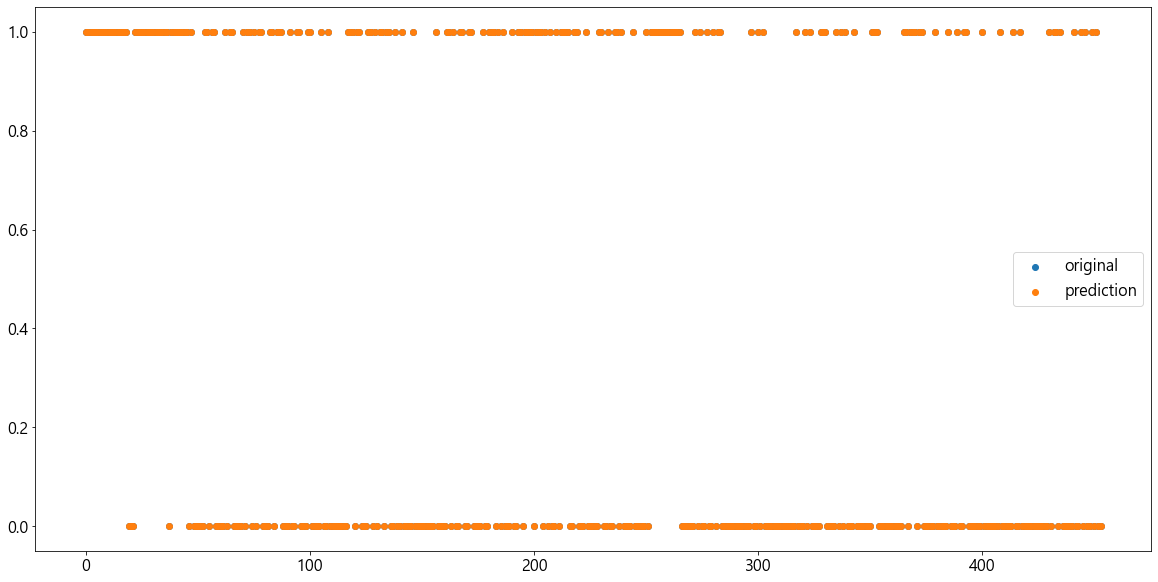

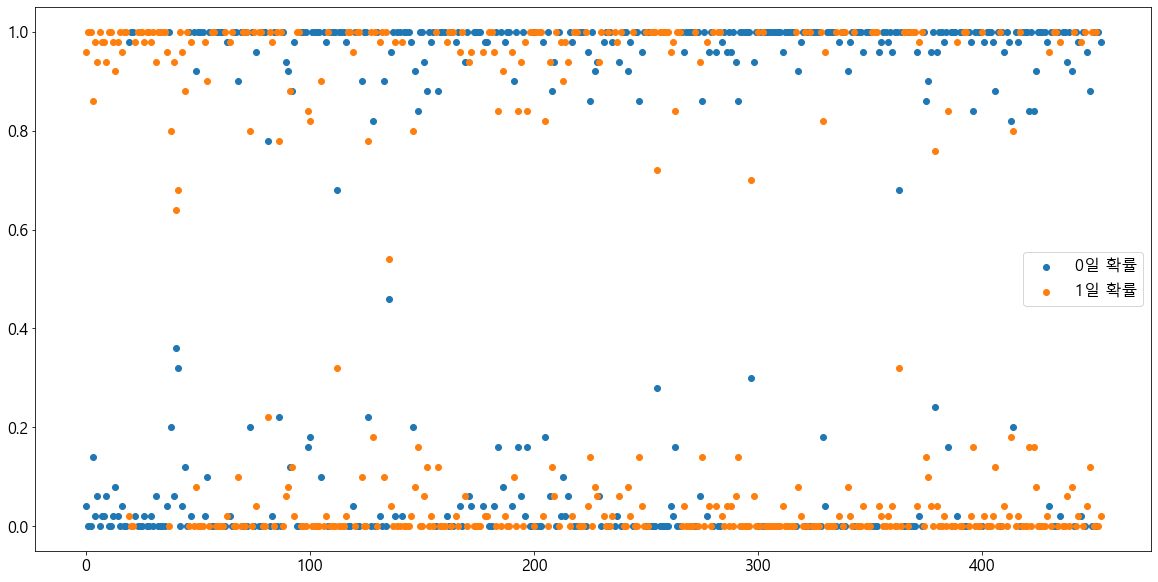

In [10]:
# 최적의 하이퍼파라미터가 셋팅된 모델을 받아온다.
best_model1 = grid_clf1.best_estimator_

# 학습
best_model1.fit(X, y)

# 예측결과를 시각화 해본다.
y_pred1 = best_model1.predict(X)

plt.scatter(list(range(len(y))), y, label='original')
plt.scatter(list(range(len(y_pred1))), y_pred1, label='prediction')
plt.legend()
plt.show()

# 결과 확률
proba_a1 = best_model1.predict_proba(X)

# 0일 확률들
a10 = proba_a1[:, 0]
# 1일 확률들
a11 = proba_a1[:, 1]

plt.scatter(list(range(len(a10))), a10, label='0일 확률')
plt.scatter(list(range(len(a11))), a11, label='1일 확률')
plt.legend()
plt.show()

### 새로운 데이터에 대한 예측을 수행한다.

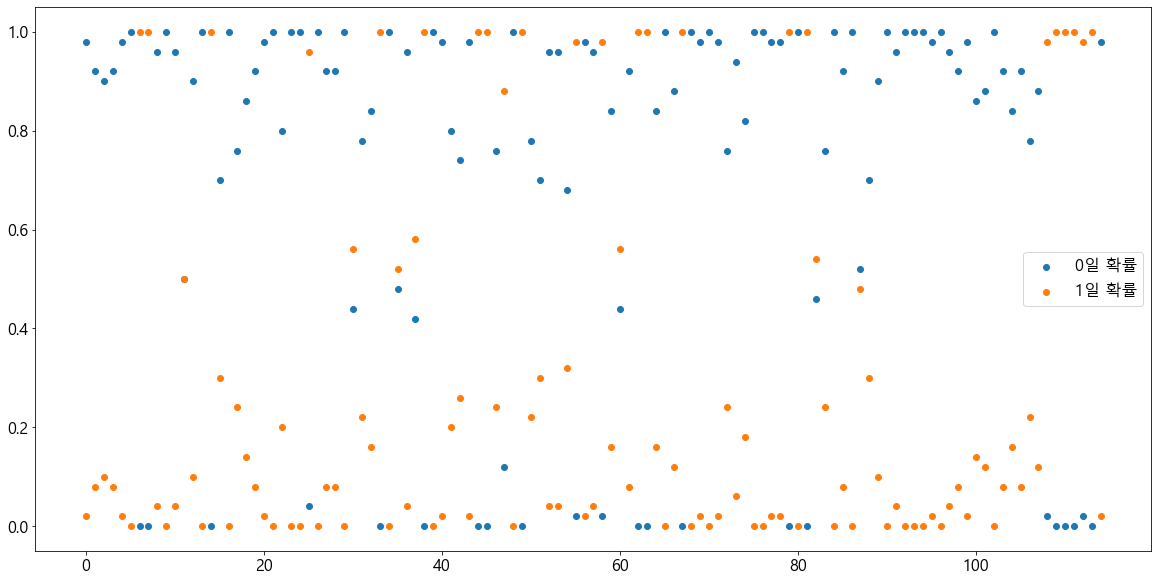

저장완료


In [12]:
df2 = pd.read_csv('data/breast_cancer_new.csv')

# 데이터 표준화
scaled_data = scaler1.transform(df2)

# 결과를 예측한다.
y_pred1 = best_model1.predict(scaled_data)

# 예측 확률을 시각화한다.
proba_data = best_model1.predict_proba(scaled_data)

# 0일확률과 1일 확률 값을 각각 가져온다.
a10 = proba_data[:, 0]
a11 = proba_data[:, 1]

plt.scatter(list(range(len(a10))), a10, label='0일 확률')
plt.scatter(list(range(len(a11))), a11, label='1일 확률')
plt.legend()
plt.show()

# 결과 데이터를 복원한다.
result_data1 = encoder1.inverse_transform(y_pred1)

# 결과를 저장한다.
df2['target'] = result_data1
df2.to_csv('data/breast_cancer_RandomForest.csv')

print('저장완료')


# 회귀

### 학습 위한 데이터 처리

In [13]:
df1 = pd.read_csv('data/boston.csv')

X = df1.drop('target', axis=1)
y = df1['target']

# 표준화
scaler1 = StandardScaler()
scaler1.fit(X)
X = scaler1.transform(X)

display(X)
display(y)


array([[-0.63326028,  0.12485095, -1.03628034, ..., -1.07088823,
         0.41031054, -0.92655695],
       [-0.60097475, -0.58885279, -0.25831126, ...,  0.06047401,
         0.41031054, -0.22972861],
       [-0.60100552, -0.58885279, -0.25831126, ...,  0.06047401,
         0.31149419, -1.08568842],
       ...,
       [-0.56479774, -0.58885279, -0.56557636, ...,  1.14658176,
         0.23574309, -0.80930218],
       [-0.5854857 , -0.58885279, -0.56557636, ...,  1.14658176,
         0.22821654, -0.63006989],
       [-0.58205565, -0.58885279, -0.56557636, ...,  1.14658176,
         0.41031054, -0.41901131]])

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
331    17.1
332    19.4
333    22.2
334    20.7
335    21.1
Name: target, Length: 336, dtype: float64

### 기본 모델 사용하기

In [14]:
model1 = RandomForestRegressor()

# 교차 검증 수행
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

r1 = cross_val_score(model1, X, y, scoring='r2', cv=kfold)

print(f'평균 성능 수치 : {r1.mean()}')


평균 성능 수치 : 0.8978355952935004


### 모델 하이퍼 파라미터 튜닝

In [15]:
# n_estimators : 트리의 개수
# max_depth : 최대 질문 생성 깊이
params = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

model1 = RandomForestRegressor()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid_clf1 = GridSearchCV(model1, param_grid=params, scoring='r2', cv=kfold)
start = datetime.datetime.now()
grid_clf1.fit(X, y)
end = datetime.datetime.now()
print(f'최적의 하이퍼 파라미터 : {grid_clf1.best_params_}')
print(f'최적의 모델 평균성능 : {grid_clf1.best_score_}')
print(f"실행시간{end - start}")


최적의 하이퍼 파라미터 : {'max_depth': None, 'n_estimators': 150}
최적의 모델 평균성능 : 0.8998586850982042
실행시간0:07:10.171786


### 최적의 모델에 학습 데이터를 통한 검증을 수행한다.

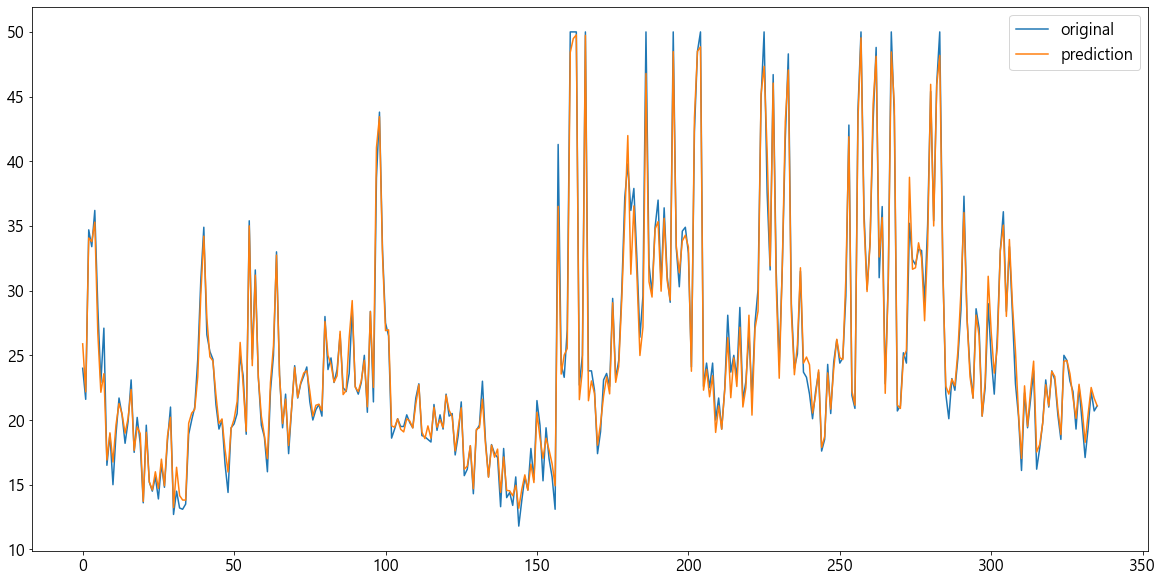

In [17]:
# 최적의 학습모델을 추출한다.
best_model1 = grid_clf1.best_estimator_

# 전체 데이터를 학습시킨다.
best_model1.fit(X, y)

# 학습 데이터를 통해 예측 결과를 가져온다
y_pred1 = best_model1.predict(X)

# 진짜 결과와 예측 결과를 시각화하여 패턴을 확인한다.
plt.plot(y, label='original')
plt.plot(y_pred1, label='prediction')
plt.legend()
plt.show()


### 예측 결과 추출

In [18]:
df2 = pd.read_csv('data/boston_new.csv')

scaled_data = scaler1.transform(df2)

y_pred1 = best_model1.predict(scaled_data)

df2['target'] = y_pred1
df2.to_csv('data/boston_RandomForest.csv')

print('저장완료')
y_pred1


저장완료


array([20.24533333, 20.74733333, 21.52066667, 20.688     , 20.62066667,
       33.45933333, 25.62933333, 27.208     , 30.63466667, 20.46333333,
       19.74866667, 25.86333333, 27.60266667, 30.44866667, 25.67866667,
       27.566     , 21.76266667, 30.096     , 21.254     , 22.24333333,
       16.32666667, 18.95666667, 19.88266667, 19.522     , 22.91533333,
       19.05466667, 19.38866667, 17.34533333, 44.35666667, 21.64066667,
       17.54      , 17.61333333, 21.94466667, 27.702     , 34.86466667,
       22.994     , 21.20333333, 13.49733333, 13.49733333, 34.04333333,
       16.22466667, 23.794     , 15.10733333, 15.05133333, 31.156     ,
       16.502     , 15.08733333, 15.082     , 15.22266667, 14.53333333,
       14.02266667, 15.79266667, 14.14333333, 14.63866667, 15.46      ,
       15.82133333, 14.59266667, 17.89933333, 15.80333333, 16.33533333,
       16.46066667, 14.91333333, 14.72733333, 16.48866667, 14.92333333,
       15.38733333, 15.102     , 14.66133333, 15.826     , 14.75

In [ ]:
# 부스팅(Boosting)
- 기본적으로는 랜덤 포레스트와 유사하다.
- 다른 점은 각 트리들이 던지는 답의 오차들을 보정하여 성능을 끌어 올린다.
- 너어어어어어어어어어어무 느려요~ㅠㅠ

- xgboost 설치
- pip install xgboost
